In [2]:
import os
import base64
import time
import datetime
from email.mime.text import MIMEText
from typing import TypedDict, List, Optional

from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

class GraphState(TypedDict):
    """
    State of email automation graph.
    """
    gmail_service: any
    project_details: str
    client_email: str
    max_reminders: int
    initial_subject: Optional[str]
    email_thread_id: Optional[str]
    initial_history_id: Optional[int]
    reminder_count: int
    last_communication_date: Optional[str]
    client_response: Optional[str]
    summary: Optional[str]
    suggested_actions: Optional[List[str]]
    user_choice: Optional[str] # <-- NEW: To hold the user's interactive choice
    status: str

#GMAIL FUNCTIONS

SCOPES = ['https://mail.google.com/']

def format_date_for_email(iso_date_str: str) -> str:
    if not iso_date_str:
        return ""
    date_obj = datetime.datetime.fromisoformat(iso_date_str).date()
    day = date_obj.day
    if 4 <= day <= 20 or 24 <= day <= 30:
        suffix = "th"
    else:
        suffix = ["st", "nd", "rd"][day % 10 - 1]
    return date_obj.strftime(f"{day}{suffix} %B %Y")

def get_gmail_service():
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
    try:
        service = build('gmail', 'v1', credentials=creds)
        print("Gmail service created successfully.")
        return service
    except HttpError as error:
        print(f'An error occurred: {error}')
        return None

def send_email_live(service, to: str, subject: str, body: str, thread_id: Optional[str] = None) -> tuple[str | None, int | None]:
    try:
        message = MIMEText(body)
        message['To'] = to
        message['Subject'] = subject
        
        create_message = {'raw': base64.urlsafe_b64encode(message.as_bytes()).decode()}
        if thread_id:
            create_message['threadId'] = thread_id

        sent_message = service.users().messages().send(userId="me", body=create_message).execute()
        print(f"Message sent. ID: {sent_message['id']}")
        
        thread_details = service.users().threads().get(userId='me', id=sent_message['threadId']).execute()
        new_history_id = thread_details.get('historyId')

        return sent_message['threadId'], new_history_id
    except HttpError as error:
        print(f'An error occurred while sending email: {error}')
        return None, None

def check_for_response_live(service, thread_id: str, initial_history_id: int) -> tuple[str | None, int | None]:
    print("\n--- POLLING FOR REPLY ---")
    start_time = time.time()
    timeout = 60
    
    while time.time() - start_time < timeout:
        try:
            history = service.users().history().list(userId='me', startHistoryId=initial_history_id).execute()
            
            if 'history' in history:
                for hist in history['history']:
                    if 'messagesAdded' in hist:
                        for message in hist['messagesAdded']:
                            if message['message']['threadId'] == thread_id:
                                msg = message['message']
                                if 'UNREAD' in msg['labelIds']:
                                    full_msg = service.users().messages().get(userId='me', id=msg['id']).execute()
                                    headers = full_msg['payload']['headers']
                                    sender = next((h['value'] for h in headers if h['name'] == 'From'), "")
                                    
                                    if service.users().getProfile(userId='me').execute()['emailAddress'] not in sender:
                                        print("\nSUCCESS: New reply found!")
                                        service.users().messages().modify(userId='me', id=msg['id'], body={'removeLabelIds': ['UNREAD']}).execute()
                                        new_history_id = history.get('historyId')
                                        return full_msg.get('snippet'), new_history_id
            time.sleep(10)
            print(f"Polling... ({int(time.time() - start_time)}s elapsed)")
        except HttpError as error:
            print(f'An API error occurred: {error}')
            return None, None
    
    print("--- TIMEOUT REACHED ---")
    return None, initial_history_id

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.7)

#GRAPH NODES

def initialization_node(state: GraphState) -> dict:
    print("\n---NODE: INITIALIZATION---")
    
    service = state['gmail_service']
    project_details = input("Project Details: ")
    client_email = input("Client Email: ")
    max_reminders = int(input("How many reminders should be sent? "))

    print("\nUsing Gemini to generate a professional email draft...")
    prompt = f"""
    Based on the project details: "{project_details}", generate a concise, professional email to a client.
    Provide the output as a simple string with "Subject:" on the first line, followed by the email body. Do 
    not include the client's name, only the company name if mentioned in Project Details. Finally, sign off 
    the email with the  company name, Inventive.
    """
    response = model.invoke(prompt)
    email_content = response.content
    print("AI Draft Generated.")

    try:
        subject_line = email_content.split('\n')[0].replace("Subject: ", "").strip()
        email_body = "\n".join(email_content.split('\n')[1:]).strip()
    except IndexError:
        subject_line = f"Proposal: {project_details}"
        email_body = "Please see attached proposal." #todo - Personalize email body response

    thread_id, history_id = send_email_live(service, client_email, subject_line, email_body)
    
    if thread_id and history_id:
        print(f"Initial email sent. Thread ID: {thread_id}")
        return {
            "project_details": project_details, "client_email": client_email,
            "max_reminders": max_reminders, "initial_subject": subject_line,
            "email_thread_id": thread_id, "initial_history_id": history_id, 
            "reminder_count": 0, "last_communication_date": datetime.date.today().isoformat(),
            "status": "awaiting_response"
        }
    else:
        print("Failed to send initial email. Aborting.")
        return {"status": "error"}

def check_for_response_node(state: GraphState) -> dict:
    print("\n---NODE: CHECK FOR RESPONSE---")
    service = state['gmail_service']
    thread_id = state['email_thread_id']
    history_id = state['initial_history_id']

    response_content, new_history_id = check_for_response_live(service, thread_id, history_id)

    if response_content:
        return {
            "client_response": response_content, 
            "initial_history_id": new_history_id,
            "status": "client_responded"
        }
    else:
        return {"initial_history_id": new_history_id, "status": "no_response"}
        
def send_reminder_node(state: GraphState) -> dict:
    print("\n---NODE: SEND REMINDER---")
    service = state['gmail_service']
    reminder_num = state['reminder_count'] + 1
    
    subject = f"Re: {state['initial_subject']}"
    
    print("Using Gemini to generate a dynamic reminder email body...")
    
    submission_date = format_date_for_email(state['last_communication_date'])
    
    prompt_template = f"""
    You are writing a polite follow-up email about a proposal.
    The proposal was submitted on {submission_date}.
    This is reminder number {reminder_num}.
    
    Please write a short, professional, and slightly varied follow-up message.
    Start with a simple greeting like "Hi," or "Hello," and mention that you are 
    following up on the proposal submitted on the given date.
    
    Do not include a subject line or your own signature.
    """
    
    if reminder_num == state['max_reminders']:
        prompt_template += '\n- Crucially, you MUST include this exact sentence at the end of the email, after a new line: '
        '"If you need more time to look into it, please let us know so that we can get back to you at a more convenient time."'

    response = model.invoke(prompt_template)
    body = response.content
    print("Dynamic reminder body generated.")

    _, new_history_id = send_email_live(service, state['client_email'], subject, body, state['email_thread_id'])

    return {
        "reminder_count": reminder_num,
        "initial_history_id": new_history_id,
        "last_communication_date": datetime.date.today().isoformat()
    }

def summarize_response_node(state: GraphState) -> dict:
    print("\n---NODE: SUMMARIZE RESPONSE---")
    prompt = f"Summarize this client email snippet concisely: '{state['client_response']}'"
    response = model.invoke(prompt)
    summary = response.content
    print(f"Summary: {summary}")
    return {"summary": summary}

def generate_choices_node(state: GraphState) -> dict:
    print("\n---NODE: GENERATE CHOICES---")
    prompt = f"""
    A client has replied to our proposal. Based on the summary of their email, determine what is the next most logical step.
    Summary: '{state['summary']}'
    
    Please suggest two concise actions. The first should be about drafting a reply. The second should be about ending the conversation.
    Format them as a numbered list.
    Example:
    1. Draft a reply to address their questions.
    2. Mark conversation as complete.
    """
    actions_text = model.invoke(prompt).content
    actions = [line.split('. ', 1)[1] for line in actions_text.split('\n') if '. ' in line]
    return {"suggested_actions": actions}

def user_choice_node(state: GraphState) -> dict:
    """Prompts the user to choose the next action from the generated list."""
    print("\n---NODE: AWAITING USER INPUT---")
    actions = state['suggested_actions']
    print("Please choose the next action:")
    for i, action in enumerate(actions):
        print(f"{i+1}. {action}")
    
    choice = ""
    while choice not in [str(i+1) for i in range(len(actions))]:
        choice = input(f"Enter your choice (1-{len(actions)}): ")
        
    return {"user_choice": choice}

def draft_reply_node(state: GraphState) -> dict:
    """Drafts a reply using AI and saves it to the state."""
    print("\n---NODE: DRAFTING REPLY---")
    prompt = f"""
    A client sent an email which can be summarized as: '{state['summary']}'.
    Their original message snippet was: '{state['client_response']}'.
    
    Please draft a professional and helpful reply to this email. Do not include a subject line.
    """
    draft = model.invoke(prompt).content
    print("\n--- AI-Generated Draft ---")
    print(draft)
    print("--------------------------")
    # Save the draft to the state so we can send it in the next step
    return {"drafted_reply": draft}

def prompt_to_send_node(state: GraphState) -> dict:
    """Asks the user if they want to send the generated draft."""
    print("\n---NODE: CONFIRM SEND---")
    choice = ""
    while choice.lower() not in ['y', 'n']:
        choice = input("Do you want to send this draft? (y/n): ")
    # Reuse the user_choice field to store this decision
    return {"user_choice": choice}

def send_draft_node(state: GraphState) -> dict:
    """Sends the drafted email."""
    print("\n---NODE: SENDING DRAFT---")
    service = state['gmail_service']
    subject = f"Re: {state['initial_subject']}"
    body = state['drafted_reply']
    
    send_email_live(service, state['client_email'], subject, body, state['email_thread_id'])
    print("Draft sent successfully.")
    return {}

def mark_complete_node(state: GraphState):
    """A final node to mark the conversation as complete."""
    print("\n---NODE: MARKING COMPLETE---")
    print(f"The conversation with {state['client_email']} has been marked as complete.")
    return {}

def should_continue(state: GraphState) -> str:
    """Determines the next step after checking for a response."""
    if state["status"] == "client_responded":
        return "summarize"
    
    if state['reminder_count'] < state['max_reminders']:
        return "remind"
    else:
        print("Maximum reminders sent. Ending workflow.")
        return "end"

def route_after_choice(state: GraphState) -> str:
    """Routes the workflow based on the user's initial interactive choice."""
    if state['user_choice'] == '1':
        return "draft_reply"
    else:
        return "mark_complete"
        
def route_after_draft(state: GraphState) -> str:
    """Routes the workflow based on the user's decision to send the draft."""
    if state['user_choice'].lower() == 'y':
        return "send_draft"
    else:
        print("Draft discarded. Ending workflow.")
        return "end"


#ASSEMBLE GRAPH
workflow = StateGraph(GraphState)

# Add all nodes to the graph
workflow.add_node("initializer", initialization_node)
workflow.add_node("checker", check_for_response_node)
workflow.add_node("reminder", send_reminder_node)
workflow.add_node("summarizer", summarize_response_node)
workflow.add_node("choice_generator", generate_choices_node)
workflow.add_node("user_prompt", user_choice_node)
workflow.add_node("draft_reply", draft_reply_node)
workflow.add_node("prompt_to_send", prompt_to_send_node)
workflow.add_node("send_draft", send_draft_node)
workflow.add_node("mark_complete", mark_complete_node)

# Set the entry point and standard edges
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "checker")
workflow.add_edge("reminder", "checker")
workflow.add_edge("summarizer", "choice_generator")
workflow.add_edge("choice_generator", "user_prompt")
workflow.add_edge("draft_reply", "prompt_to_send")

# End the graph after these final actions
workflow.add_edge("send_draft", END)
workflow.add_edge("mark_complete", END)

# Add the conditional edges
workflow.add_conditional_edges(
    "checker",
    should_continue,
    {"summarize": "summarizer", "remind": "reminder", "end": END}
)
workflow.add_conditional_edges(
    "user_prompt",
    route_after_choice,
    {"draft_reply": "draft_reply", "mark_complete": "mark_complete"}
)
workflow.add_conditional_edges(
    "prompt_to_send",
    route_after_draft,
    {"send_draft": "send_draft", "end": END}
)


app = workflow.compile()

# --- 7. MAIN EXECUTION BLOCK ---

if __name__ == "__main__":
    print("Starting Email Automation Workflow...")
    gmail_service = get_gmail_service()

    if gmail_service:
        initial_state = {
            "gmail_service": gmail_service,
            "reminder_count": 0,
        }
        for event in app.stream(initial_state):
            for node, output in event.items():
                print(f"--- Output from node '{node}' ---")
                print(output)
                print("\n" + "="*30 + "\n")
    else:
        print("Could not create Gmail service. Exiting.")


Starting Email Automation Workflow...
Gmail service created successfully.

---NODE: INITIALIZATION---


ValueError: invalid literal for int() with base 10: ''

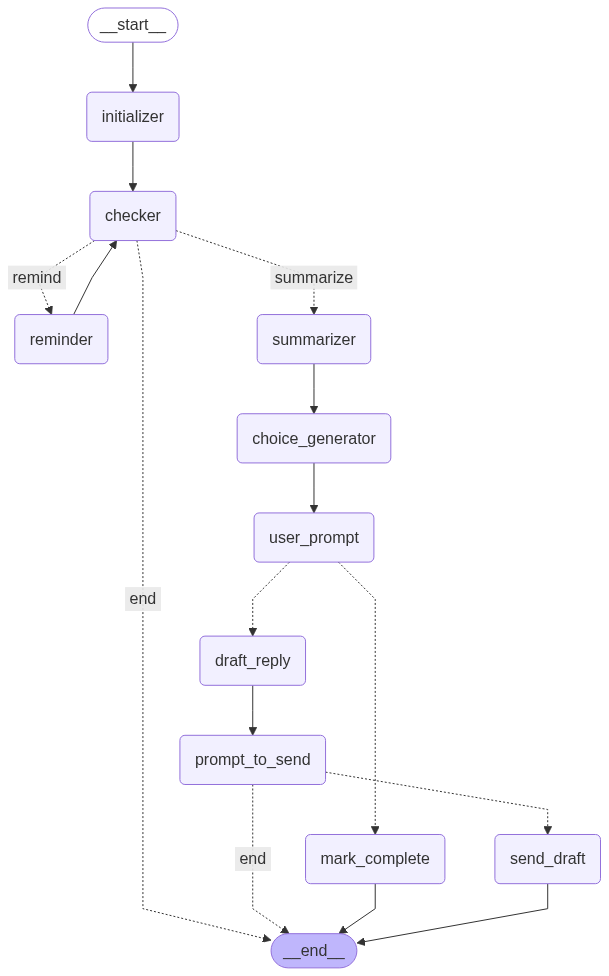

In [3]:
from IPython.display import Image, display

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))
